### KEYS

In [1]:
import json
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
import seaborn as sns
import scipy
from scipy import stats
from scipy.stats import mannwhitneyu
stats.junk = lambda chisq, df: stats.chi2.sf(chisq, df)
import csv
import gffpandas.gffpandas as gffpd

### IDENTIFYING HIGH AND LOW EXPRESSION GENES

In [2]:
CC2344 = ["CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
CC2931 = ["CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]

#### OPENING FILES ####
CC2344_avg_fpkm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2344_avg_fpkm', delimiter = '\t', index_col = 'index')
CC2931_avg_fpkm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2931_avg_fpkm', delimiter = '\t', index_col = 'index')

#### 10TH PERCENTILE - LOW EXPRESSION GENES ####
CC2931_ANC_10 = np.percentile(CC2931_avg_fpkm['CC2931-ANC'], 10)
CC2344_ANC_10 = np.percentile(CC2344_avg_fpkm['CC2344-ANC'], 10)

#### 90TH PERCENTILE - HIGH EXPRESSION GENES ####
CC2931_ANC_90 = np.percentile(CC2931_avg_fpkm['CC2931-ANC'], 90)
CC2344_ANC_90 = np.percentile(CC2344_avg_fpkm['CC2344-ANC'], 90)

#### ISOLATING HIGH/LOW EXPRESSION GENES IN ANCESTRAL LINES ####
CC2931_hi_exp = list(CC2931_avg_fpkm.loc[CC2931_avg_fpkm['CC2931-ANC'] >= CC2931_ANC_90].index.values)
CC2931_low_exp = list(CC2931_avg_fpkm.loc[CC2931_avg_fpkm['CC2931-ANC'] <= CC2931_ANC_10].index.values)

CC2344_hi_exp = list(CC2344_avg_fpkm.loc[CC2344_avg_fpkm['CC2344-ANC'] >= CC2344_ANC_90].index.values)
CC2344_low_exp = list(CC2344_avg_fpkm.loc[CC2344_avg_fpkm['CC2344-ANC'] <= CC2344_ANC_10].index.values)

#### ISOLATING HIGH/LOW EXPRESSION GENES IN MA LINES #####
HL_MAgenes = {}
for i in CC2344 + CC2931:
    if 'CC2344' in i:
        HL_MAgenes[i + "_low"] = list(CC2344_avg_fpkm.loc[CC2344_avg_fpkm[i] <= CC2344_ANC_10].index.values)
        HL_MAgenes[i + "_hi"] = list(CC2344_avg_fpkm.loc[CC2344_avg_fpkm[i] >= CC2344_ANC_90].index.values)
    if 'CC2931' in i:
        HL_MAgenes[i + "_low"] = list(CC2931_avg_fpkm.loc[CC2931_avg_fpkm[i] <= CC2931_ANC_10].index.values)
        HL_MAgenes[i + "_hi"] = list(CC2931_avg_fpkm.loc[CC2931_avg_fpkm[i] >= CC2931_ANC_90].index.values)
        
#### SHARED EXPRESSIONS ACROSS GENOTYPES ####
shared_high_expression = set.intersection(set(CC2931_hi_exp), set(CC2344_hi_exp))
shared_low_expression = set.intersection(set(CC2931_low_exp), set(CC2344_low_exp))

#### OVERLAPS BETWEEN HIGH AND LOW EXPRESSION ####
overlap_1 = set.intersection(set(CC2931_hi_exp), set(CC2344_low_exp))
overlap_2 = set.intersection(set(CC2931_low_exp), set(CC2344_hi_exp))

### EXTRACTING GENE LOCATIONS VIA GFF FILE

In [44]:
# annotation = gffpd.read_gff3('/research/projects/chlamydomonas/MAexpression/data/genome_info/v6_genome_plus_anno/CC4532.v1_1.gene_exons.gff3')
# mRNA = annotation.df
# mRNA['attributes'] = mRNA['attributes'].str.split(';', expand = True)
# type_gene = mRNA.loc[mRNA['type'] == 'gene']
# type_gene['attributes'] = type_gene['attributes'].str.replace('ID=', '', regex = True)
# type_gene['length'] = 'nan'
# for i in list(type_gene.index.values):
#     type_gene.at[i, 'length'] = type_gene.at[i, 'end'] - type_gene.at[i, 'start']
# type_gene.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/annotation/v6_genes.csv', sep = '\t', header = True, index = False)

# #### ADDING THE GENE NAME TO EACH MRNA TYPE ####
# type_gene = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/annotation/v6_genes.csv', delimiter = '\t')
# type_mRNA = pd.DataFrame()
# for i in list(type_gene.index.values):
#     chromosome = mRNA.loc[mRNA['seq_id'] == type_gene.loc[i, 'seq_id']]
#     pacid = chromosome.loc[chromosome['type'] == 'mRNA']
#     section = pacid.loc[(pacid['start'] == type_gene.at[i, 'start']) | (pacid['end'] == type_gene.at[i, 'end'])]
#     section['genename'] = type_gene.loc[i, 'attributes']
#     type_mRNA = type_mRNA.append(section)
# type_mRNA.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/annotation/v6_mRNA.csv', sep = '\t', index = False, header = True)

# #### ASSIGNING A GENENAME TO EACH CDS, EXON AND UTR ####
# edited_mRNA = pd.DataFrame()
# type_mRNA = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/annotation/v6_mRNA.csv', delimiter = '\t')
# for i in list(type_mRNA.index.values):
#     prefix = type_mRNA.loc[i, 'attributes']
#     section = mRNA.loc[mRNA['attributes'].str.startswith(prefix)]
#     section['genename'] = type_mRNA.at[i, 'genename']
#     edited_mRNA = pd.concat([edited_mRNA, section])
# edited_mRNA.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/annotation/edited_v6_annotation.csv', sep = '\t', index = False, header = True)

<ipython-input-44-21b178197ea9>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  section['genename'] = type_mRNA.at[i, 'genename']


### ISOLATING THE LOCATION OF EACH MUTATION USING GFF FILE

In [33]:
#### OPENING ANNOTATION GFF FILES ####
# type_gene = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/annotation/v6_genes.csv', delimiter = '\t')

# #### OPENING FILE WITH MUTATIONS AND THEIR KNOWN LOCATIONS IN V6 ####
# mutations = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/mutation_info/v6_coordinates.bed', delimiter = '\t', names = ['chromosome', 'start', 'end', 'sample'])
# mutations['sample'] = mutations['sample'].str.replace('_', '-L', regex = True)
# mutations = mutations.sort_values('sample') # There are two missing samples CC2931_8 and CC2931_12, the first one has no recorded mutations
# mutations['gene'] = 'intergenic'
# mutations['gene_start'] = np.nan
# mutations['gene_end'] = np.nan

# #### REMOVING ALL CC2931_12 MUTATIONS FROM THE DATAFRAME ####
# missing_CC2931_12 = mutations.loc[mutations['sample'] == 'CC2931-L12'].index.values
# mutations.drop(missing_CC2931_12, inplace = True)

# #### FIND THE GENE THE MUTATION OCCURRED ####
# for i in list(mutations.index.values):
#     spec_chrom = type_gene.loc[type_gene['seq_id'] == mutations.at[i, 'chromosome']]
#     spec_chrom = spec_chrom.loc[(spec_chrom['start'] <= mutations.at[i, 'start']) & (spec_chrom['end'] >= mutations.at[i, 'start'])]
#     if len(spec_chrom) != 0:
#         mutations.at[i, 'gene'] = spec_chrom['attributes'].values[0]
#         mutations.at[i, 'gene_start'] = spec_chrom['start'].values[0]
#         mutations.at[i, 'gene_end'] = spec_chrom['end'].values[0]
#     if mutations.at[i, 'gene'] == 'intergenic':
#         mutations.at[i, 'gene_start'] = mutations.at[i, 'start']
#         mutations.at[i, 'gene_end'] = mutations.at[i, 'end']
# mutations.to_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/mutation_info/all_mutations.csv', sep = "\t", index = False, header = True)

### ISOLATING THE MUTATIONS ENRICHED IN EXONS, CDS, AND UTRS ####

(array([0, 1, 2]),
 [Text(0, 0, 'five_prime_UTR'),
  Text(1, 0, 'CDS'),
  Text(2, 0, 'three_prime_UTR')])

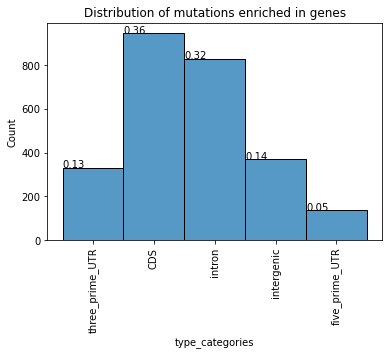

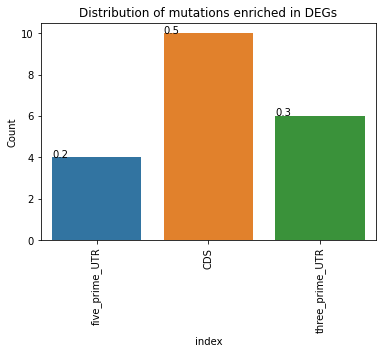

In [15]:
### ISOLATING THE MUTATIONS IN DIFFERNTIALLY EXPRESSED GENES (DEGs) ANNOTATED ####
CC2344 = ["CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
CC2931 = ["CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]

DEGs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes1.csv', delimiter = ',').reset_index()
DEGs = pd.melt(DEGs, id_vars = ['index'], value_vars = CC2344 + CC2931).dropna()

### ISOLATING THE DISTRIBUTION OF MUTATIONS ENRICHED IN GENES ####
mutations = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/mutation_info/all_mutations.csv', delimiter = '\t')
mutations['type'] = 'intron'
mutations['type_categories'] = 'intron'

annotation = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/annotation/edited_v6_annotation.csv', delimiter = '\t')

for i in mutations.index.values:
    if mutations.at[i, 'gene'] == 'intergenic':
        mutations.at[i, 'type'] = 'intergenic'
        mutations.at[i, 'type_categories'] = 'intergenic'
    else:
        section = annotation.loc[annotation['genename'] == mutations.at[i, 'gene']]
        exon = section.loc[section['type'] == 'exon']
        for a in exon.index.values:
            if exon.at[a, 'start'] <= mutations.at[i, 'start'] and mutations.at[i, 'end'] <= exon.at[a, 'end']:
                mutations.at[i, 'type'] = 'exon'
        five_prime_UTR = section.loc[section['type'] == 'five_prime_UTR']
        for a in five_prime_UTR.index.values:
            if five_prime_UTR.at[a, 'start'] <= mutations.at[i, 'start'] and mutations.at[i, 'end'] <= five_prime_UTR.at[a, 'end']:
                mutations.at[i, 'type_categories'] = 'five_prime_UTR'
        three_prime_UTR = section.loc[section['type'] == 'three_prime_UTR']
        for a in three_prime_UTR.index.values:
            if three_prime_UTR.at[a, 'start'] <= mutations.at[i, 'start'] and mutations.at[i, 'end'] <= three_prime_UTR.at[a, 'end']:
                mutations.at[i, 'type_categories'] = 'three_prime_UTR'
        cds = section.loc[section['type'] == 'CDS']
        for a in cds.index.values:
            if cds.at[a, 'start'] <= mutations.at[i, 'start'] and mutations.at[i, 'end'] <= cds.at[a, 'end']:
                mutations.at[i, 'type_categories'] = 'CDS'
# mutations.to_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/mutation_info/all_mutations1.csv', sep = '\t', header = True, index = False)

#### ISOLATING THE DISTRIBUTION OF MUTATIONS ENRICHED IN DEGS ####
enriched_DEGs = pd.DataFrame()
for i in CC2344 + CC2931:
    sample = DEGs.loc[DEGs['variable'] == i]['value'].values.tolist()
    spec_mut = mutations.loc[(mutations['gene'].isin(sample)) & (mutations['sample'] == i)]
    enriched_DEGs[i] = spec_mut['type_categories'].value_counts()
enriched_DEGs = enriched_DEGs.replace(np.nan, 0, regex = True)
enriched_DEGs['sum'] = enriched_DEGs.sum(axis = 1)

#### PLOTS ####
ax = sns.histplot(data = mutations, x = 'type_categories')
for p in ax.patches:
    txt = p.get_height()
    x = p.get_x()
    y = p.get_height()
    ax.text(x, y, str((txt/2613).round(2)))
plt.title('Distribution of mutations enriched in genes')
plt.xticks(rotation=90)

plt.figure()
ax1 = sns.barplot(data = enriched_DEGs.reset_index(), x = 'index', y = 'sum')
for a in ax1.patches:
    txt = a.get_height()
    x = a.get_x()
    y = a.get_height()
    ax1.text(x, y, str((txt/20).round(2)))
plt.ylabel('Count')
plt.title('Distribution of mutations enriched in DEGs')
plt.xticks(rotation=90)

###  SIMULATIONS - ISOLATING THE MUTATIONS ENRICHED IN EXONS, CDS, AND UTRS

In [4]:
# ### ISOLATING THE MUTATIONS IN DIFFERNTIALLY EXPRESSED GENES (DEGs) ANNOTATED ####
# CC2344 = ["CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
# CC2931 = ["CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]

# distribution = pd.DataFrame(columns = ['intron', 'intergenic', 'five_prime_UTR', 'three_prime_UTR', 'CDS'])

# #### IMPORTING DEGS ####
# DEGs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes1.csv', delimiter = ',').reset_index()
# DEGs = pd.melt(DEGs, id_vars = ['index'], value_vars = CC2344 + CC2931).dropna()

# #### IMPORTING THE ANNOTATION FOR GENES IN VERSION 6 ####
# type_gene = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/annotation/v6_genes.csv', delimiter = '\t')
# annotation = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/annotation/edited_v6_annotation.csv', delimiter = '\t')

# #### IMPORTING TOTAL BASE COUNT PER CHROMOSOME ####
# base_counts = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/chrom_base_count', skiprows=2, delimiter = '\t', index_col = 'chromosome')

# ### ISOLATING THE DISTRIBUTION OF MUTATIONS ENRICHED IN GENES ####
# mutations = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/mutation_info/all_mutations.csv', delimiter = '\t')
# mutations['type'] = 'intron'
# mutations['type_categories'] = 'intron'

# for trials in range(1000):
#     #### CREATING SIMULATED MUTATIONS ####
#     simulated_mutations = mutations
#     simulated_mutations['gene'] = 'intergenic'
#     simulated_mutations['gene_start'] = np.nan
#     simulated_mutations['gene_end'] = np.nan

#     #### RANDOMLY CHOOSING MUTATIONS ACROSS THE GENOME ####
#     for b in simulated_mutations.index.values:
#         chrom = np.random.choice(list(base_counts.index.values), 1, replace = True)
#         location = np.random.randint(1, base_counts.at[chrom[0], 'base_counts'])
#         simulated_mutations.at[b, 'chromosome'] = chrom[0]
#         simulated_mutations.at[b, 'start'] = location
#         simulated_mutations.at[b, 'end'] = location + 1

#     #### FIND THE GENE THE MUTATION OCCURRED ####
#     for i in list(simulated_mutations.index.values):
#         spec_chrom = type_gene.loc[type_gene['seq_id'] == simulated_mutations.at[i, 'chromosome']]
#         spec_chrom = spec_chrom.loc[(spec_chrom['start'] <= simulated_mutations.at[i, 'start']) & (spec_chrom['end'] >= simulated_mutations.at[i, 'start'])]
#         if len(spec_chrom) != 0:
#             simulated_mutations.at[i, 'gene'] = spec_chrom['attributes'].values[0]
#             simulated_mutations.at[i, 'gene_start'] = spec_chrom['start'].values[0]
#             simulated_mutations.at[i, 'gene_end'] = spec_chrom['end'].values[0]
#         if simulated_mutations.at[i, 'gene'] == 'intergenic':
#             simulated_mutations.at[i, 'gene_start'] = mutations.at[i, 'start']
#             simulated_mutations.at[i, 'gene_end'] = mutations.at[i, 'end']

#     for i in simulated_mutations.index.values:
#         if simulated_mutations.at[i, 'gene'] == 'intergenic':
#             simulated_mutations.at[i, 'type'] = 'intergenic'
#             simulated_mutations.at[i, 'type_categories'] = 'intergenic'
#         else:
#             section = annotation.loc[annotation['genename'] == simulated_mutations.at[i, 'gene']]
#             exon = section.loc[section['type'] == 'exon']
#             for a in exon.index.values:
#                 if exon.at[a, 'start'] <= simulated_mutations.at[i, 'start'] and simulated_mutations.at[i, 'end'] <= exon.at[a, 'end']:
#                     simulated_mutations.at[i, 'type'] = 'exon'
#             five_prime_UTR = section.loc[section['type'] == 'five_prime_UTR']
#             for a in five_prime_UTR.index.values:
#                 if five_prime_UTR.at[a, 'start'] <= simulated_mutations.at[i, 'start'] and simulated_mutations.at[i, 'end'] <= five_prime_UTR.at[a, 'end']:
#                     simulated_mutations.at[i, 'type_categories'] = 'five_prime_UTR'
#             three_prime_UTR = section.loc[section['type'] == 'three_prime_UTR']
#             for a in three_prime_UTR.index.values:
#                 if three_prime_UTR.at[a, 'start'] <= simulated_mutations.at[i, 'start'] and simulated_mutations.at[i, 'end'] <= three_prime_UTR.at[a, 'end']:
#                     simulated_mutations.at[i, 'type_categories'] = 'three_prime_UTR'
#             cds = section.loc[section['type'] == 'CDS']
#             for a in cds.index.values:
#                 if cds.at[a, 'start'] <= simulated_mutations.at[i, 'start'] and simulated_mutations.at[i, 'end'] <= cds.at[a, 'end']:
#                     simulated_mutations.at[i, 'type_categories'] = 'CDS'
                    
#     #### ISOLATING THE DISTRIBUTION OF MUTATIONS ENRICHED IN DEGS ####
#     enriched_DEGs = pd.DataFrame(index = ['intron', 'intergenic', 'five_prime_UTR', 'three_prime_UTR', 'CDS'])
#     for i in CC2344 + CC2931:
#         sample = DEGs.loc[DEGs['variable'] == i]['value'].values.tolist()
#         spec_mut = simulated_mutations.loc[(simulated_mutations['gene'].isin(sample)) & (simulated_mutations['sample'] == i)]
#         enriched_DEGs[i] = spec_mut['type_categories'].value_counts()
#         enriched_DEGs = enriched_DEGs.replace(np.nan, 0, regex = True)
#     enriched_DEGs['sum'] = enriched_DEGs.sum(axis = 1)
#     section = pd.Series(enriched_DEGs['sum'])
#     section = section.rename('simulated_' + str(trials + 1))
#     distribution = distribution.append(section)
    
# distribution.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/genetic_distribution_of_simulated_mutations.csv', sep = '\t', index = True, header = True)

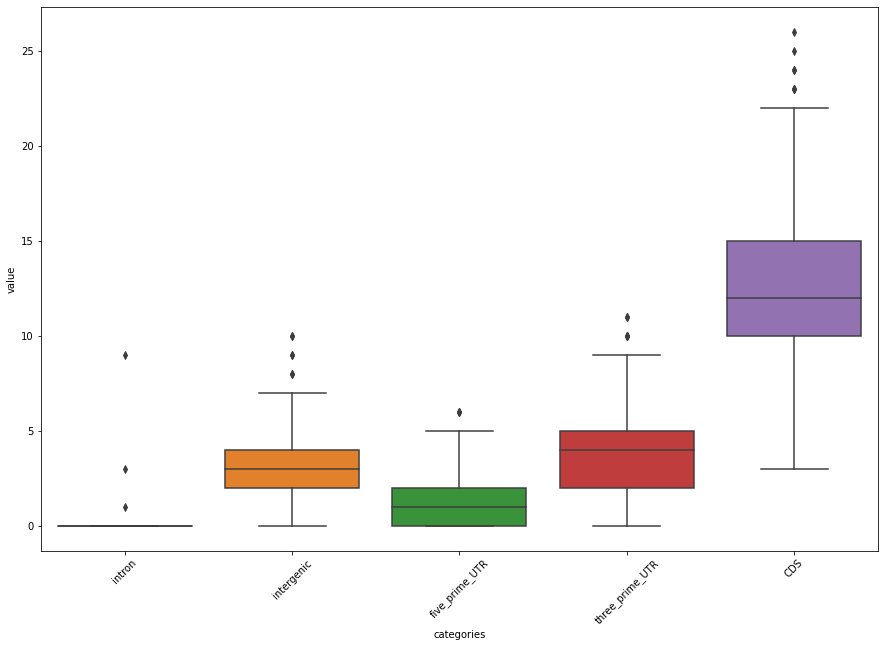

In [18]:
#### PLOTS ####
distribution = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/genetic_distribution_of_simulated_mutations.csv', delimiter = '\t', index_col = 'Unnamed: 0').reset_index()
distribution = pd.melt(distribution, id_vars = ['index'], value_vars = distribution.columns[1:])
plt.figure(figsize = (15,10))
sns.boxplot(data = distribution, x = 'variable', y = 'value')
plt.xlabel('categories')
plt.xticks(rotation = 45)
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/genetic_distribution_of_simulated_mutations.pdf', dpi = 150, format = 'pdf', bbox_inches = 'tight')

### IDENTIFYING CIS MUTATIONS

In [40]:
#### FINDING POSSIBLE CIS MUTATIONS ####
mutations = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/mutation_info/all_mutations.csv', delimiter = '\t')
cis_mutations = pd.DataFrame()

CC2344 = ["CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
CC2931 = ["CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]
total = CC2344 + CC2931

#### RENAMING THE COLUMN NAMES OF DEG FILE ####
DEGs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes.csv', delimiter = ',')
DEGs.rename(columns = {genes[i]:total[i] for i in range(len(genes))}, inplace = True)
DEGs.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes1.csv', sep = ',', index = False, header = True)

for i in total:
    DEGs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/degs_with_locations/' + i + '.csv')
    DEGs['gene_length'] = 'nan'
    DEGs['gene_midpoint'] = 'nan'
    DEGs['min_distance_to_mutations'] = 'nan'
    DEGs['sample'] = i
    sample_mutations = mutations.loc[mutations['sample'] == i]
    if len(sample_mutations) != 0:
        for a in list(DEGs.index.values):
            nearest_distance = []
            spec_mut = sample_mutations.loc[sample_mutations['chromosome'] == DEGs.at[a, 'seq_id']]
            DEGs.at[a, 'gene_length'] = DEGs.at[a, 'end'] - DEGs.at[a, 'start']
            DEGs.at[a, 'gene_midpoint'] = int((DEGs.at[a, 'end'] + DEGs.at[a, 'start'])/2)
            for e in list(spec_mut.index.values):
                nearest_distance.append(abs(DEGs.at[a, 'gene_midpoint'] - spec_mut.at[e, 'start']))
            if len(nearest_distance) != 0:
                DEGs.at[a, 'min_distance_to_mutations'] = min(nearest_distance)
                cis_mutations = cis_mutations.append(DEGs.loc[a])

cis_mutations.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/nearest_distance_from_mutations.csv', sep = '\t', index = True, header = True)        

### ISOLATING MUTATIONS IN DEGS - PERMUTATIONS TEST ###

In [5]:
#### CREATING DATAFRAMES AND DICTIONARIES ####
CC2344 = ["CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
CC2931 = ["CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]
total = CC2344 + CC2931

DEGs_dic = {}
enriched_DEGs = pd.DataFrame()

### OPENING FILES ####
mutations = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/mutation_info/all_mutations.csv', delimiter = '\t')
DEGs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes1.csv', delimiter = ',')
DEGs = DEGs.replace('intergenic', np.nan, regex = True)

for i in DEGs.columns:
    DEGs_dic[i] = DEGs[i].dropna().values.tolist()
    
#### IDENTIFYING MUTATIONS ENRICHED IN OBSERVED DEGS ####
for i in CC2344 + CC2931:
    gene_list = DEGs_dic[i]
    spec_mut = mutations.loc[mutations['sample'] == i].groupby('gene').count().reset_index()
    unique_mut = spec_mut['gene'].values.tolist()
    intersect = list(set(gene_list).intersection(set(unique_mut)))
    a = spec_mut.loc[spec_mut['gene'].isin(intersect)]
    enriched_DEGs.at['observed', i] = a['chromosome'].sum()
    
#### IMPORTING THE ANNOTATION FOR GENES IN VERSION 6 ####
v6_genes = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/annotation/v6_genes.csv', delimiter = '\t')

#### IMPORTING TOTAL BASE COUNT PER CHROMOSOME ####
base_counts = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/chrom_base_count', skiprows=2, delimiter = '\t', index_col = 'chromosome')

for trials in range(1000):
    simulated_DEGs = pd.DataFrame()
    for sample in CC2344 + CC2931:
        #### CREATING SIMULATED GENES ####
        simulated_genes = pd.DataFrame(index = [e for e in range(len(DEGs_dic[sample]))], columns = ['start', 'end', 'chromosome', 'gene_start', 'gene_end', 'gene_length', 'gene_midpoint', 'min_distance_to_mutations'])

        #### RANDOMLY CHOOSING GENES ACROSS THE GENOME ####
        for b in range(len(DEGs_dic[sample])):
            chrom = np.random.choice(list(base_counts.index.values), 1, replace = True)
            location = np.random.randint(1, base_counts.at[chrom[0], 'base_counts'])
            simulated_genes.at[b, 'chromosome'] = chrom[0]
            simulated_genes.at[b, 'start'] = location
            simulated_genes.at[b, 'end'] = location + 1

        #### ASSIGNING THE GENE NAME TO EACH SIMULATED GENE ####
        simulated_genes['gene'] = 'intergenic'
        for i in range(len(DEGs_dic[sample])):
            specific_chrom = v6_genes.loc[v6_genes['seq_id'] == simulated_genes.at[i, 'chromosome']]
            for a in list(specific_chrom.index.values):
                if specific_chrom.at[a, 'start'] <= simulated_genes.at[i, 'start'] and specific_chrom.at[a, 'end'] >= simulated_genes.at[i, 'start']:
                    simulated_genes.at[i, 'gene'] = specific_chrom.at[a, 'attributes']
                    simulated_genes.at[i, 'gene_start'] = specific_chrom.at[a, 'start']
                    simulated_genes.at[i, 'gene_end'] = specific_chrom.at[a, 'end']
        if simulated_genes.at[i, 'gene'] == 'intergenic':
            simulated_genes.at[i, 'gene_start'] = simulated_genes.at[i, 'start']
            simulated_genes.at[i, 'gene_end'] = simulated_genes.at[i, 'end']
        simulated_DEGs[sample] = simulated_genes['gene']
    simulated_DEGs = simulated_DEGs.replace('intergenic', np.nan, regex = True)

    # #### IDENTIFYING MUTATIONS ENRICHED IN SIMULATED DEGS ####
    for i in CC2344 + CC2931:
        gene_list = simulated_DEGs[i].dropna().values.tolist()
        spec_mut = mutations.loc[mutations['sample'] == i].groupby('gene').count().reset_index()
        unique_mut = spec_mut['gene'].values.tolist()
        intersect = list(set(gene_list).intersection(set(unique_mut)))
        a = spec_mut.loc[spec_mut['gene'].isin(intersect)]
        enriched_DEGs.at['simulated_' + str(trials), i] = a['chromosome'].sum()
enriched_DEGs.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/enriched_DEGs.csv', sep = '\t', index = True, header = True)

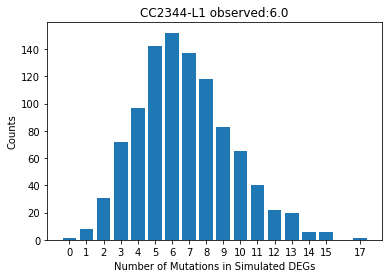

<Figure size 432x288 with 0 Axes>

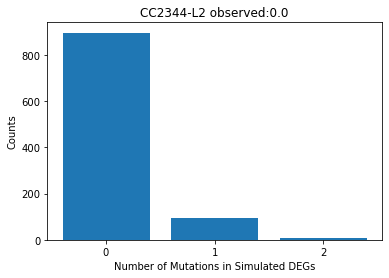

<Figure size 432x288 with 0 Axes>

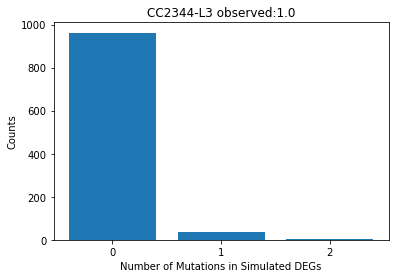

<Figure size 432x288 with 0 Axes>

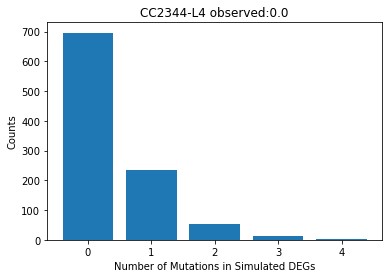

<Figure size 432x288 with 0 Axes>

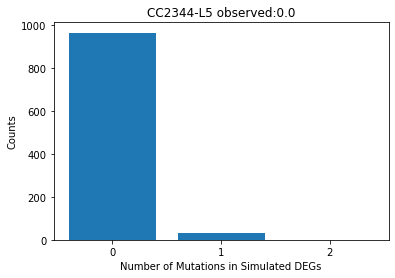

<Figure size 432x288 with 0 Axes>

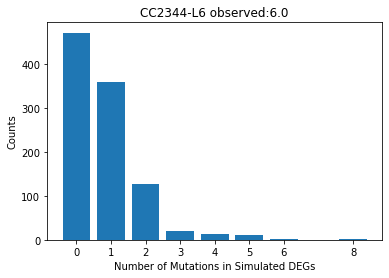

<Figure size 432x288 with 0 Axes>

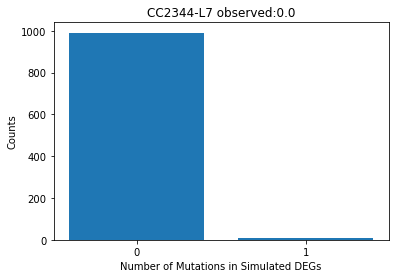

<Figure size 432x288 with 0 Axes>

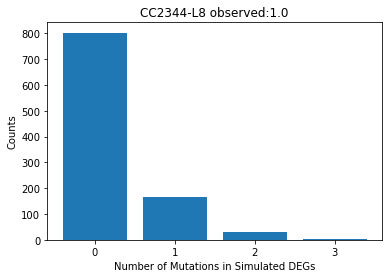

<Figure size 432x288 with 0 Axes>

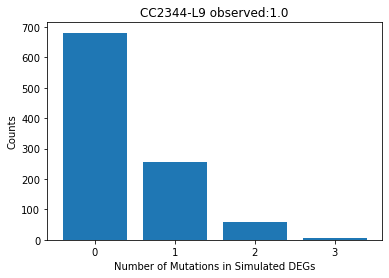

<Figure size 432x288 with 0 Axes>

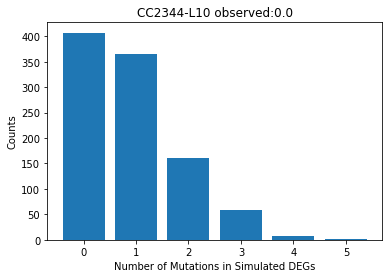

<Figure size 432x288 with 0 Axes>

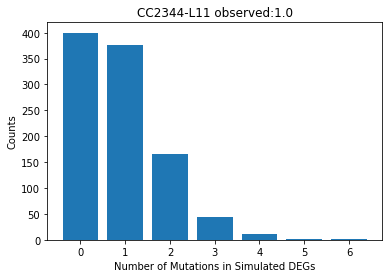

<Figure size 432x288 with 0 Axes>

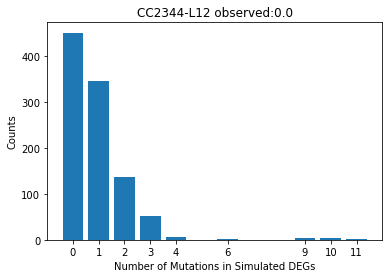

<Figure size 432x288 with 0 Axes>

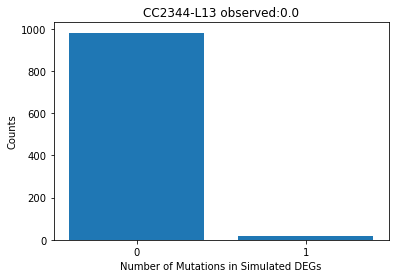

<Figure size 432x288 with 0 Axes>

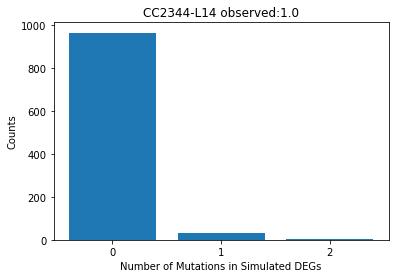

<Figure size 432x288 with 0 Axes>

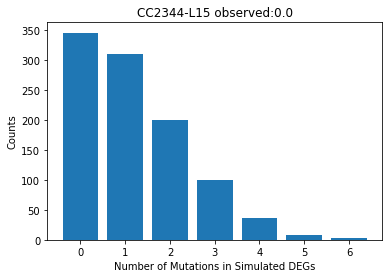

<Figure size 432x288 with 0 Axes>

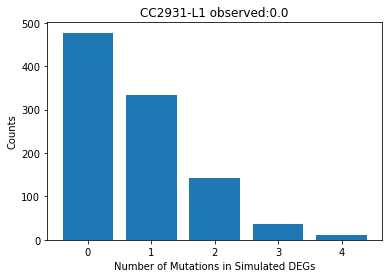

<Figure size 432x288 with 0 Axes>

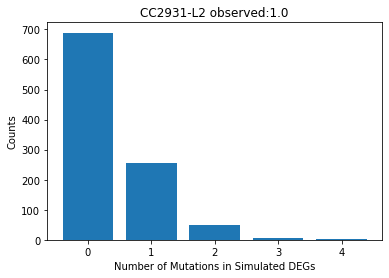

<Figure size 432x288 with 0 Axes>

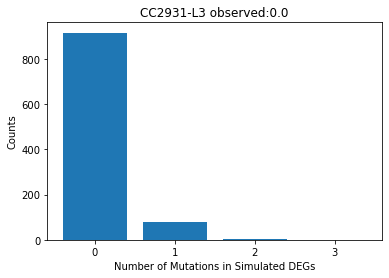

<Figure size 432x288 with 0 Axes>

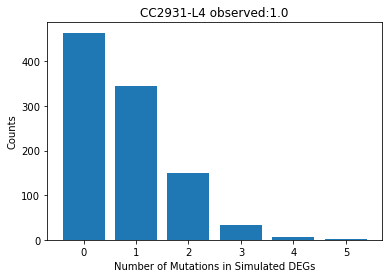

<Figure size 432x288 with 0 Axes>

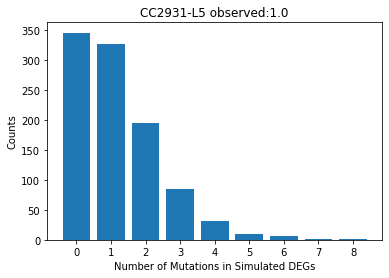

<Figure size 432x288 with 0 Axes>

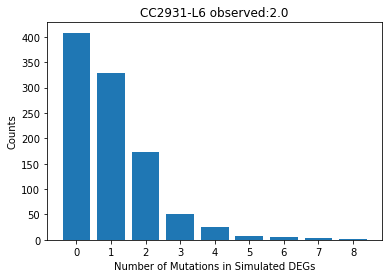

<Figure size 432x288 with 0 Axes>

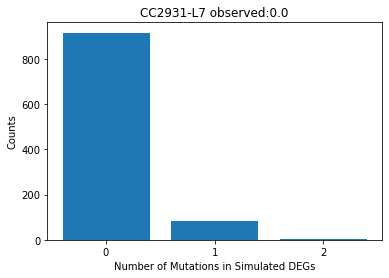

<Figure size 432x288 with 0 Axes>

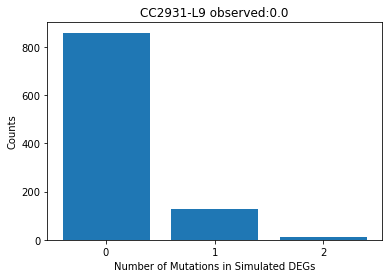

<Figure size 432x288 with 0 Axes>

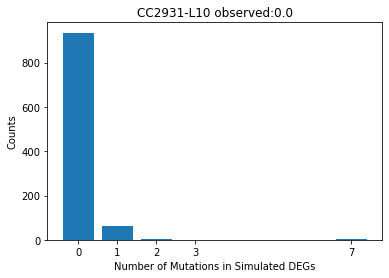

<Figure size 432x288 with 0 Axes>

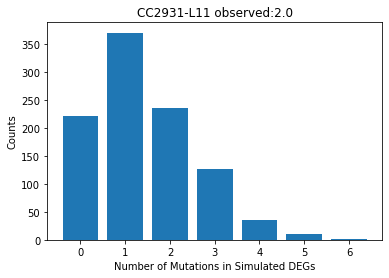

<Figure size 432x288 with 0 Axes>

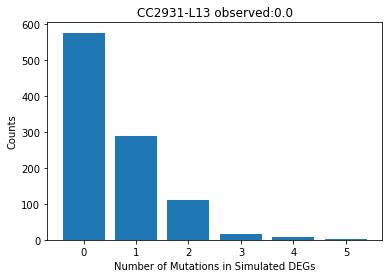

<Figure size 432x288 with 0 Axes>

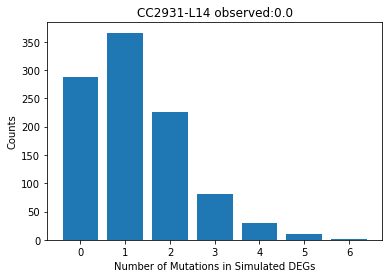

<Figure size 432x288 with 0 Axes>

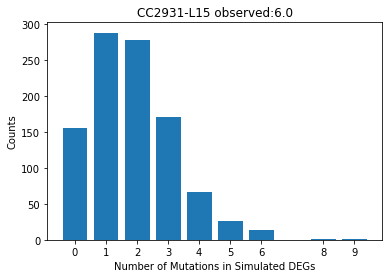

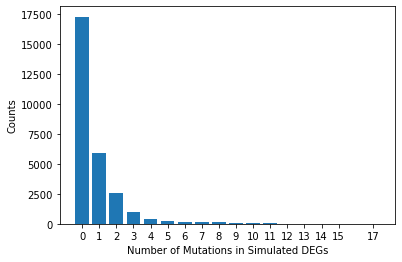

<Figure size 432x288 with 0 Axes>

In [3]:
#### PLOTS ####
simulated_DEGs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/simulated_enriched_DEGs.csv', delimiter = '\t', index_col = 'Unnamed: 0')
for i in CC2344 + CC2931:
    plt.figure()
    labels, counts = np.unique(simulated_DEGs[i], return_counts=True)
    plt.bar(labels, counts, align='center')
    plt.gca().set_xticks(labels)
    plt.title(i + ' observed:' + str(simulated_DEGs.at['observed', i]))
    plt.ylabel('Counts')
    plt.xlabel('Number of Mutations in Simulated DEGs')
    plt.show()
    plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/mutations_enriched_simulated_DEGs/' + i + '.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')
    
reformated_simulated_DEGs = simulated_DEGs.reset_index()
reformated_simulated_DEGs = pd.melt(reformated_simulated_DEGs, id_vars = ['index'], value_vars = CC2344 + CC2931)
labels, counts = np.unique(reformated_simulated_DEGs['value'], return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.ylabel('Counts')
plt.xlabel('Number of Mutations in Simulated DEGs')
plt.show()
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/mutations_enriched_simulated_DEGs/combined_counts.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

### FINDING THE NEAREST DISTANCE BETWEEN MUTATIONS AND SIMULATED GENES

In [22]:
def simulated_genes(sample, trials):
    '''simulated trials to determine the null hypothesis for cis mutations'''
    total_cis_mutations = pd.DataFrame()
    for trials in range(trials):
        #### CREATING DATAFRAMES AND DICTIONARIES ####
        cis_mutations = pd.DataFrame()
        DEGs_dic = {}

        #### OPENING FILES ####
        mutations = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/mutation_info/all_mutations.csv', delimiter = '\t')
        mutations['sample'] = mutations['sample'].str.replace('_', '-L', regex = True)
        DEGs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes.csv', delimiter = ',')

        #### RENAMING COLUMN NAMES IN DEGS DATAFRAME ####
        CC2344 = ["CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
        CC2931 = ["CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]
        total = CC2344 + CC2931
        genes = ['CC2344.resSig_L1.genes', 'CC2344.resSig_L2.genes', 'CC2344.resSig_L3.genes', 'CC2344.resSig_L4.genes',
                 'CC2344.resSig_L5.genes', 'CC2344.resSig_L6.genes', 'CC2344.resSig_L7.genes', 'CC2344.resSig_L8.genes',
                 'CC2344.resSig_L9.genes', 'CC2344.resSig_L10.genes', 'CC2344.resSig_L11.genes', 'CC2344.resSig_L12.genes',
                 'CC2344.resSig_L13.genes', 'CC2344.resSig_L14.genes', 'CC2344.resSig_L15.genes', 'CC2931.resSig_L1.genes',
                 'CC2931.resSig_L2.genes', 'CC2931.resSig_L3.genes', 'CC2931.resSig_L4.genes', 'CC2931.resSig_L5.genes',
                 'CC2931.resSig_L6.genes', 'CC2931.resSig_L7.genes', 'CC2931.resSig_L9.genes', 'CC2931.resSig_L10.genes',
                 'CC2931.resSig_L11.genes', 'CC2931.resSig_L13.genes', 'CC2931.resSig_L14.genes', 'CC2931.resSig_L15.genes']
        dic = {genes[i]:total[i] for i in range(len(genes))}
        DEGs = DEGs.rename(columns = dic)

        for i in DEGs.columns:
            DEGs_dic[i] = DEGs[i].dropna().values.tolist()

        simulated_genes = pd.DataFrame(index = [e for e in range(len(DEGs_dic[sample]))], columns = ['start', 'end', 'chromosome', 'gene_start', 'gene_end', 'gene_length', 'gene_midpoint', 'min_distance_to_mutations'])
        simulated_genes['trial'] = 'trial_' + trials
        
        #### ISOLATING THE LOCATION OF EACH SIMULATED MUTATION ####
        annotation = gffpd.read_gff3('/research/projects/chlamydomonas/MAexpression/data/genome_info/v6_genome_plus_anno/CC4532.v1_1.gene_exons.gff3')
        mRNA = annotation.df
        mRNA['attributes'] = mRNA['attributes'].str.split(';', expand = True)
        mRNA = mRNA.loc[mRNA['type'] == 'gene']
        mRNA['attributes'] = mRNA['attributes'].str.replace('ID=', '', regex = True)
        mRNA['length'] = 'nan'
        for i in list(mRNA.index.values):
            mRNA.at[i, 'length'] = mRNA.at[i, 'end'] - mRNA.at[i, 'start']

        #### IMPORTING TOTAL BASE COUNT PER CHROMOSOME ####
        base_counts = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/chrom_base_count', skiprows=2, delimiter = '\t', index_col = 'chromosome')

        #### RANDOMLY CHOOSING GENES ACROSS THE GENOME ####
        for b in range(len(DEGs_dic[sample])):
            chrom = np.random.choice(list(base_counts.index.values), 1, replace = True)
            location = np.random.randint(1, base_counts.at[chrom[0], 'base_counts'])
            simulated_genes.at[b, 'chromosome'] = chrom[0]
            simulated_genes.at[b, 'start'] = location
            simulated_genes.at[b, 'end'] = location + 1

        #### ASSIGNING THE GENE NAME TO EACH SIMULATED GENE ####
        simulated_genes['gene'] = 'intergenic'
        for i in range(len(DEGs_dic[sample])):
            specific_chrom = mRNA.loc[mRNA['seq_id'] == simulated_genes.at[i, 'chromosome']]
            for a in list(specific_chrom.index.values):
                if specific_chrom.at[a, 'start'] <= simulated_genes.at[i, 'start'] and specific_chrom.at[a, 'end'] >= simulated_genes.at[i, 'start']:
                    simulated_genes.at[i, 'gene'] = specific_chrom.at[a, 'attributes']
                    simulated_genes.at[i, 'gene_start'] = specific_chrom.at[a, 'start']
                    simulated_genes.at[i, 'gene_end'] = specific_chrom.at[a, 'end']
            if simulated_genes.at[i, 'gene'] == 'intergenic':
                simulated_genes.at[i, 'gene_start'] = simulated_genes.at[i, 'start']
                simulated_genes.at[i, 'gene_end'] = simulated_genes.at[i, 'end']

        #### IDENTIFYING THE NEAREST DISTANCE BETWEEN MUTATIONS AND GENES ####
        sample_mutations = mutations.loc[mutations['sample'] == sample]
        if len(sample_mutations) != 0:
            for a in list(simulated_genes.index.values):
                nearest_distance = []
                specific_mut = sample_mutations.loc[sample_mutations['chromosome'] == simulated_genes.at[a, 'chromosome']]
                simulated_genes.at[a, 'gene_length'] = simulated_genes.at[a, 'gene_end'] - simulated_genes.at[a, 'gene_start']
                simulated_genes.at[a, 'gene_midpoint'] = int((simulated_genes.at[a, 'gene_end'] + simulated_genes.at[a, 'gene_start'])/2)
                for e in list(specific_mut.index.values):
                    nearest_distance.append(abs(simulated_genes.at[a, 'gene_midpoint'] - specific_mut.at[e, 'start']))
                if len(nearest_distance) != 0:
                    simulated_genes.at[a, 'min_distance_to_mutations'] = min(nearest_distance)
                    cis_mutations = cis_mutations.append(simulated_genes.loc[a])
        total_cis_mutations = pd.concat([total_cis_mutations, cis_mutations])
    return total_cis_mutations

## NULL HYPOTHESIS

In [29]:
#### LIST OF ALL SAMPLES ####
CC2344 = ["CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
CC2931 = ["CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]
total = CC2344 + CC2931

# for i in total:
#     trial = simulated_genes(i, 1000)
#     trial.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/null_hypothesis/nearest_distance_' + i + '.csv', sep = '\t', index = True, header = True)

# for a in total:
#     trial = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/null_hypothesis/nearest_distance_' + a + '.csv', delimiter = '\t')
#     trial['min_distance_to_mutations'] = np.log10(trial['min_distance_to_mutations'])
#     trial['groups'] = pd.cut(trial['min_distance_to_mutations'], bins = [0, 1, 2, 3, 4, 5, 6, 7])
#     sorted_trial = trial.groupby(['trial'])
#     intervals = [i for i in pd.interval_range(start=0, end=7)]
#     groups = [i for i in trial['groups'].unique().dropna()]
#     trial_counts = pd.DataFrame(index = ['trial_' + str(i) for i in range(1000)], columns = intervals)
#     for i in trial_counts.columns:
#         trial_counts[i] = 0
#     for i in range(1000):
#         for e in range(len(groups)):
#             trial_section = sorted_trial.get_group('trial_' + str(i))
#             trial_counts.at['trial_' + str(i), groups[e]] = len(trial_section.loc[trial_section['groups'] == groups[e]])
#     trial_counts.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/null_hypothesis/trial_counts_' + a + '.csv', sep = '\t', index = True, header = True)
    
#### FINDING SIGNIFICANT P VALUES AMONG SIMULATED CIS MUTATIONS ####
intervals = [i for i in pd.interval_range(start=0, end=7)]
ordered_groups = {intervals[0]:'(0, 1]', intervals[1]:'(1, 2]', intervals[2]:'(2, 3]', intervals[3]:'(3, 4]', intervals[4]:'(4, 5]',
                 intervals[5]:'(5, 6]', intervals[6]:'(6, 7]'}
ordered_groups_reverse = {value:key for (key, value) in ordered_groups.items()}

pval_stats = pd.DataFrame(columns = [i for i in intervals])
cis_mutations = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/nearest_distance_from_mutations.csv', delimiter = '\t')
cis_mutations['attributes'] = cis_mutations['attributes'].str.replace('ID=', '', regex = True)
cis_mutations['log10_min_distance_to_mutations'] = np.log10(cis_mutations['min_distance_to_mutations'])
cis_mutations['min_distance_to_mutations_groups'] = pd.cut(cis_mutations['log10_min_distance_to_mutations'], [0, 1, 2, 3, 4, 5, 6, 7])
cis_mutations = cis_mutations.groupby('sample')

for a in total:
    testing = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/null_hypothesis/trial_counts_' + a + '.csv', delimiter = '\t', index_col = 'Unnamed: 0')
    specific_group = cis_mutations.get_group(a)
    cis_mutations_count = specific_group.groupby(['min_distance_to_mutations_groups']).size().reset_index(name='counts')
    cis_mutations_count = cis_mutations_count.set_index('min_distance_to_mutations_groups').T
    for i in cis_mutations_count.columns:
        pval_stats.at[a, i] = len(testing.loc[testing[ordered_groups[i]] >= cis_mutations_count.at['counts', i]])/1000
pval_stats.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/null_hypothesis/pval_stats.csv', sep = '\t', index = True, header = True)

#### COMPILING CIS MUTATIONS BASED ON SIGNIFICANT P VALUES ####
verified_cis_mutations = pd.DataFrame()
for i in pval_stats.columns[0:4]:
    significant_section = pval_stats[i].loc[pval_stats[i] <= 0.07]
    for a in significant_section.index.values:
        specific_group = cis_mutations.get_group(a)
        specific_group = specific_group.loc[specific_group['min_distance_to_mutations_groups'] == i]
        verified_cis_mutations = pd.concat([verified_cis_mutations, specific_group])

CC2344_log2Fold = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2344_log2Fold', delimiter = '\t', index_col = 'Unnamed: 0')
CC2931_log2Fold = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2931_log2Fold', delimiter = '\t', index_col = 'Unnamed: 0')

for i in verified_cis_mutations.index.values:
    if 'CC2344' in verified_cis_mutations.at[i, 'sample']:
        verified_cis_mutations.at[i, 'log2fold'] = CC2344_log2Fold.at[verified_cis_mutations.at[i, 'attributes'], verified_cis_mutations.at[i, 'sample']]
    if 'CC2931' in verified_cis_mutations.at[i, 'sample']:
        verified_cis_mutations.at[i, 'log2fold'] = CC2931_log2Fold.at[verified_cis_mutations.at[i, 'attributes'], verified_cis_mutations.at[i, 'sample']]
        
CC2344_verified = verified_cis_mutations.loc[verified_cis_mutations['sample'].isin(CC2344)]
CC2931_verified = verified_cis_mutations.loc[verified_cis_mutations['sample'].isin(CC2931)]

#### PLOTTING THE LOG2FOLD DISTRIBUTION OF VERIFIED CIS MUTATIONS ####
fig, axes = plt.subplots(2, 1, figsize = (8, 8))
sns.violinplot(ax = axes[0], data = CC2344_verified, x = 'log2fold')
axes[0].set_xlim(-5, 5.5)
axes[0].set_title('CC2344 - VERIFIED CIS MUTATIONS')
axes[0].set(xticklabels=[])
axes[0].set_xlabel('')
sns.violinplot(ax = axes[1], data = CC2931_verified, x = 'log2fold')
axes[1].set_xlim(-5, 5.5)
axes[1].set_title('CC2931 - VERIFIED CIS MUTATIONS')

### COUNTS WITHIN EACH LOG10 DISTANCE BIN

<ipython-input-24-0798fdf02804>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


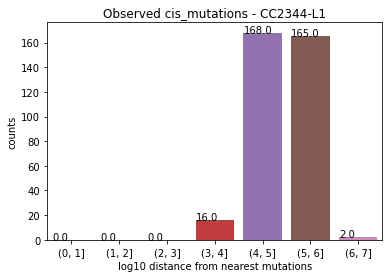

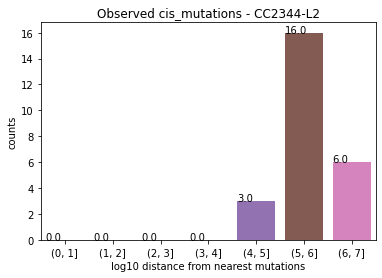

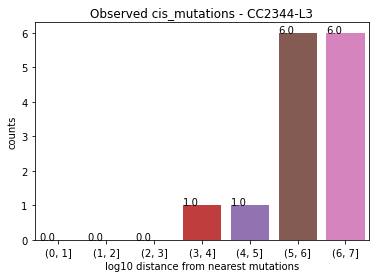

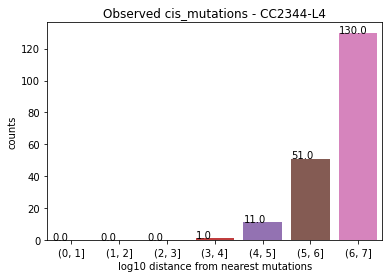

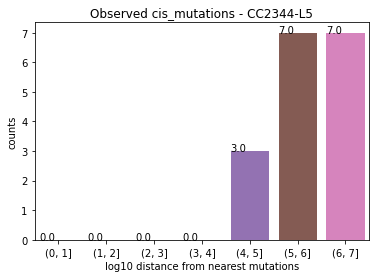

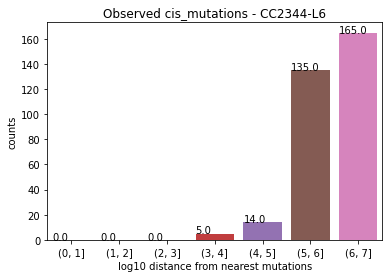

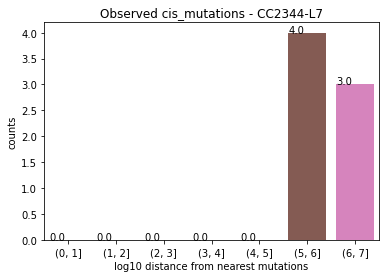

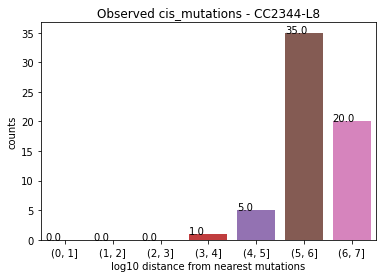

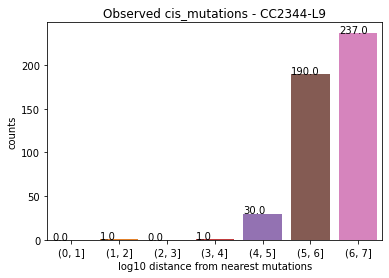

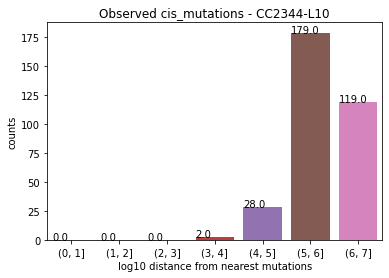

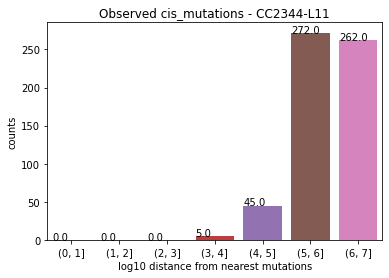

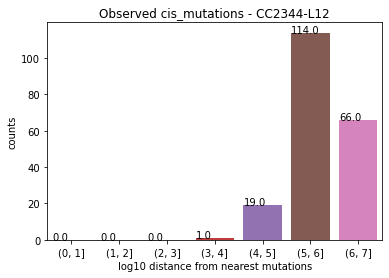

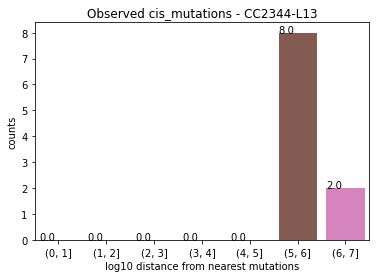

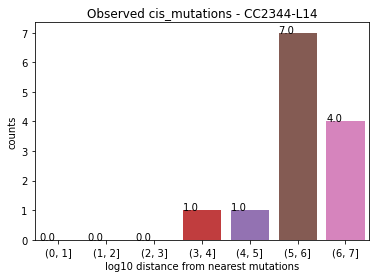

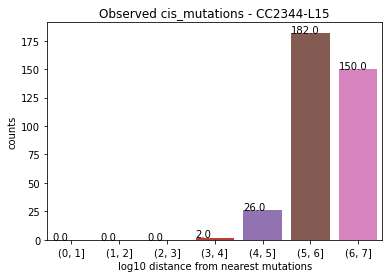

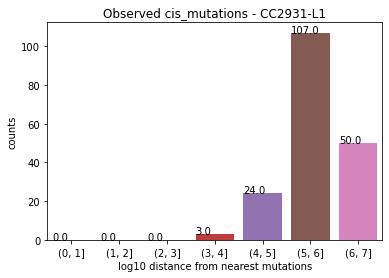

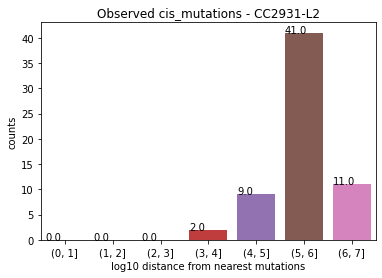

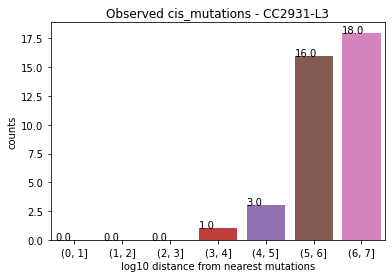

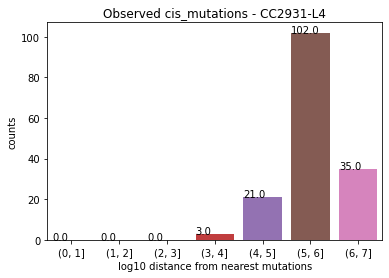

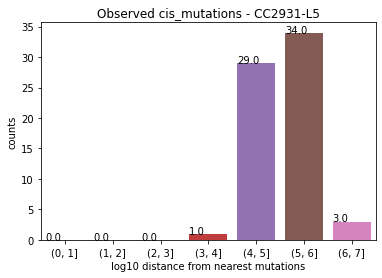

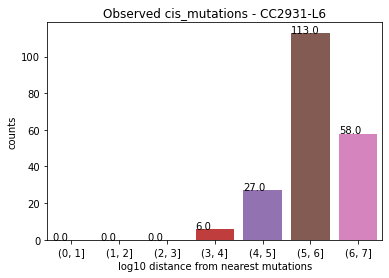

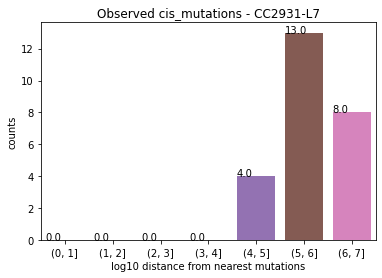

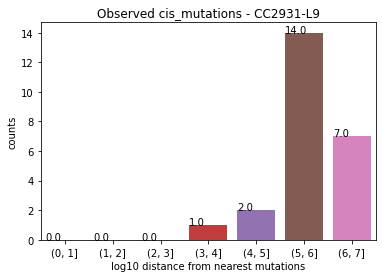

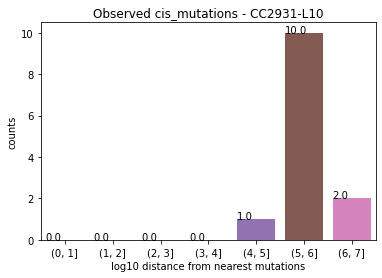

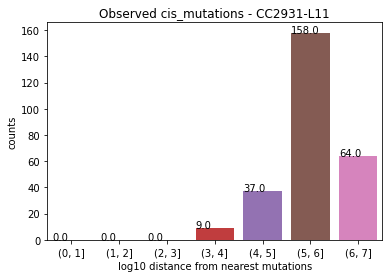

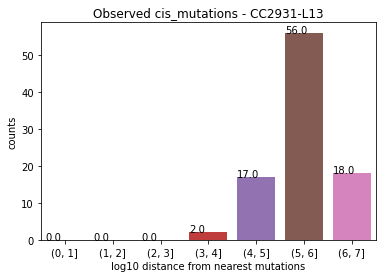

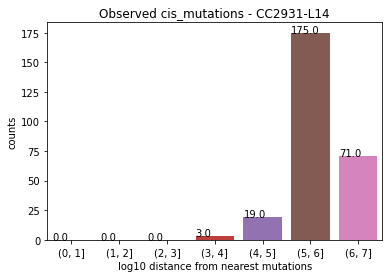

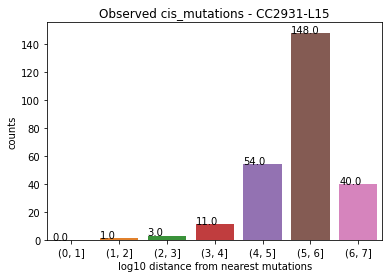

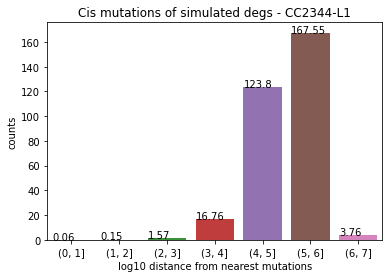

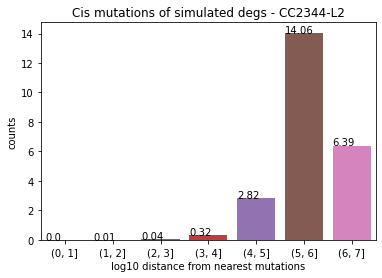

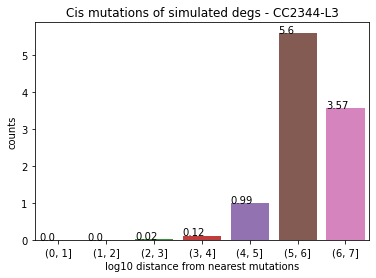

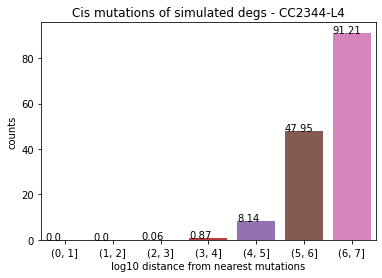

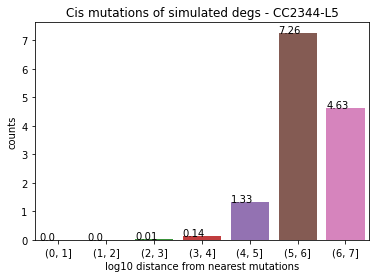

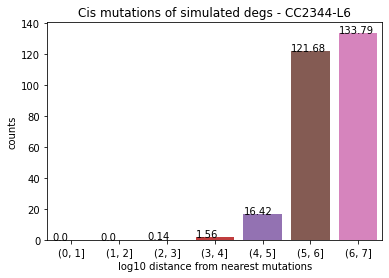

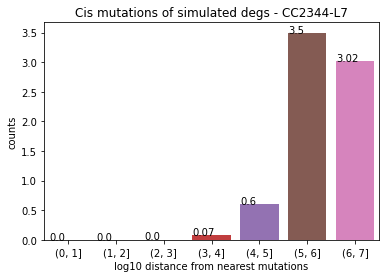

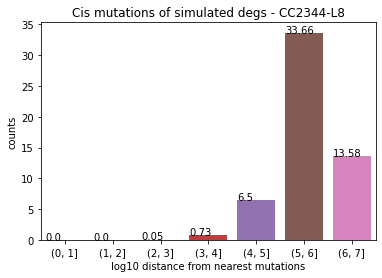

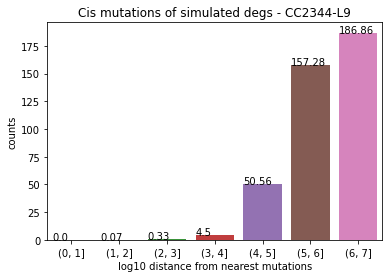

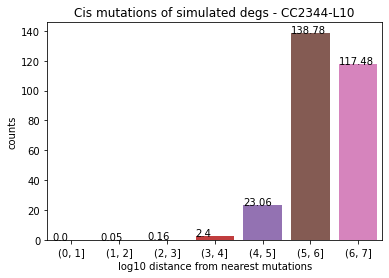

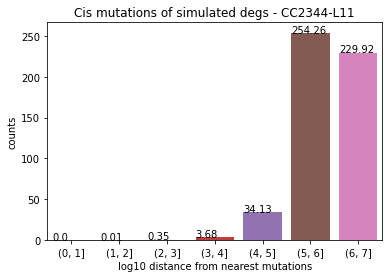

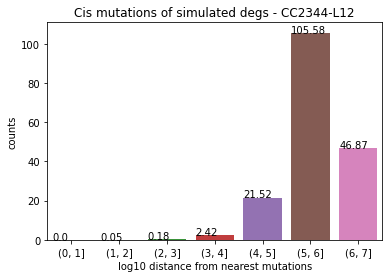

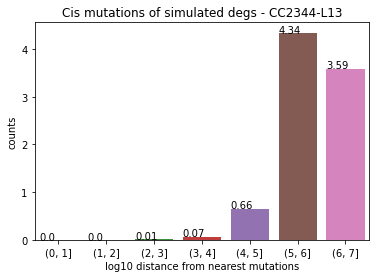

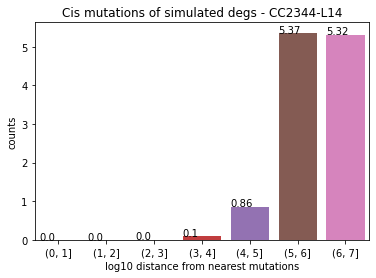

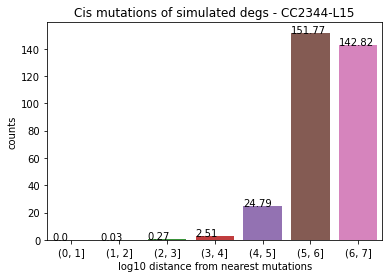

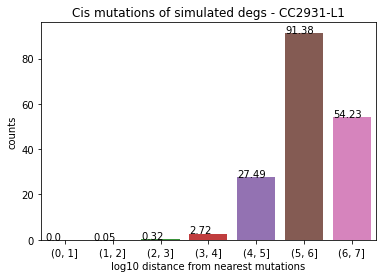

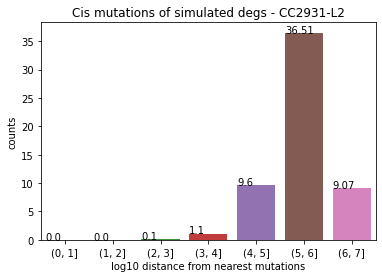

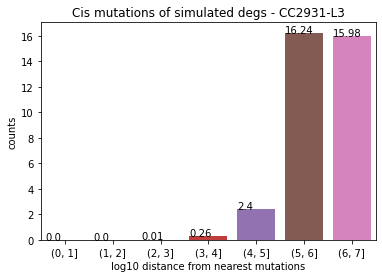

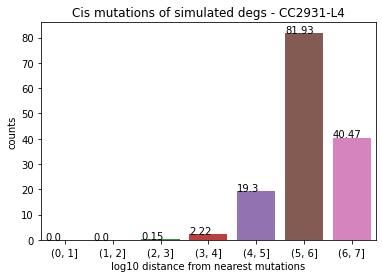

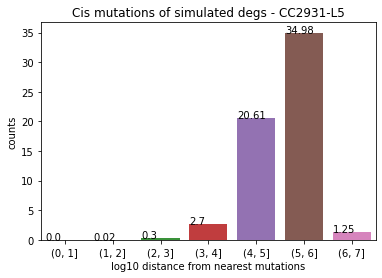

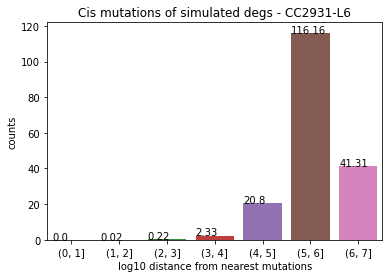

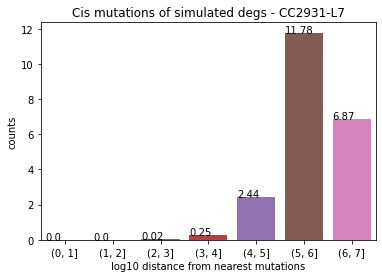

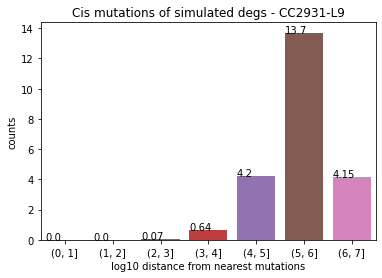

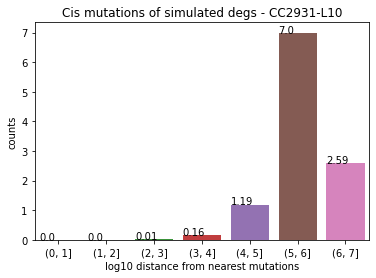

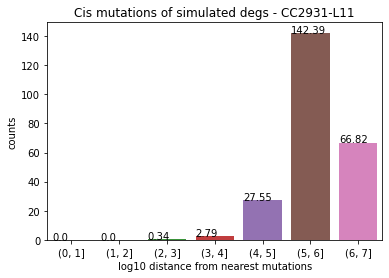

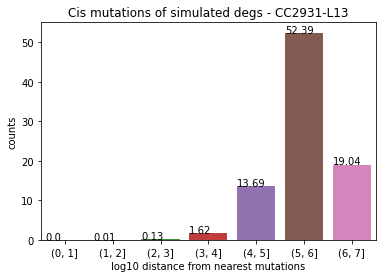

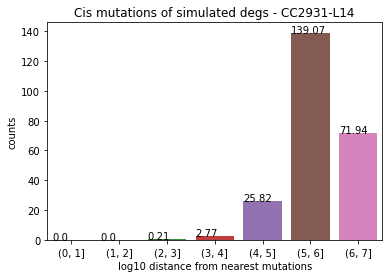

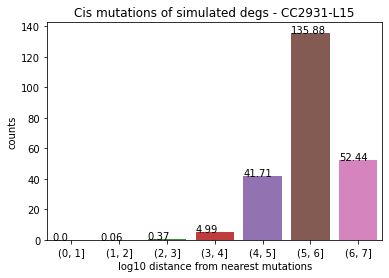

In [24]:
#### LIST OF ALL SAMPLES ####
CC2344 = ["CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
CC2931 = ["CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]
total = CC2344 + CC2931

#### OBSERVED CIS MUTATIONS ####
cis_mutations = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/nearest_distance_from_mutations.csv', delimiter = '\t')
cis_mutations['log10_min_distance_to_mutations'] = np.log10(cis_mutations['min_distance_to_mutations'])
cis_mutations['min_distance_to_mutations_groups'] = pd.cut(cis_mutations['log10_min_distance_to_mutations'], [0, 1, 2, 3, 4, 5, 6, 7])
cis_mutations = cis_mutations.groupby('sample')
for i in total:
    specific_group = cis_mutations.get_group(i)
    cis_mutations_count = specific_group.groupby(['min_distance_to_mutations_groups']).size().reset_index(name='counts')
    plt.figure()
    ax = sns.barplot(data = cis_mutations_count, x = 'min_distance_to_mutations_groups', y = 'counts')
    ax.set_title('Observed cis_mutations - ' + i)
    ax.set_xlabel('log10 distance from nearest mutations')
    for p in ax.patches:
        txt = str(p.get_height().round(2))
        x = p.get_x() 
        y = p.get_height()
        ax.text(x, y, txt)
    plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/null_hypothesis/counts_per_min_distance/observed_degs_' + i + '.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')  

#### SIMULATED DEGS ####
for i in total:
    trial = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/null_hypothesis/trial_counts_' + i + '.csv', delimiter = '\t', index_col = 'Unnamed: 0')
    group_mean_counts = pd.DataFrame(trial.mean(axis = 0)).reset_index()
    plt.figure()
    ax = sns.barplot(data = group_mean_counts, x = 'index', y = 0)
    ax.set_title('Cis mutations of simulated degs - ' + i)
    ax.set_ylabel('counts')
    ax.set_xlabel('log10 distance from nearest mutations')
    for p in ax.patches:
        txt = str(p.get_height().round(2))
        x = p.get_x()
        y = p.get_height()
        ax.text(x, y, txt)
    plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/null_hypothesis/counts_per_min_distance/simulated_degs_' + i + '.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

/home/balogu15/.conda/envs/personal/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/balogu15/.conda/envs/personal/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-4-5b66efe20f61>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


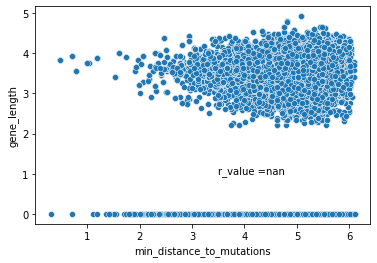

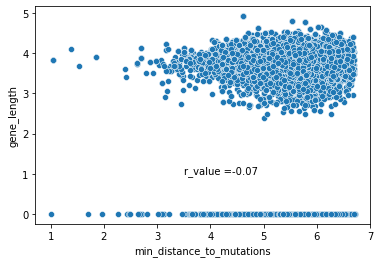

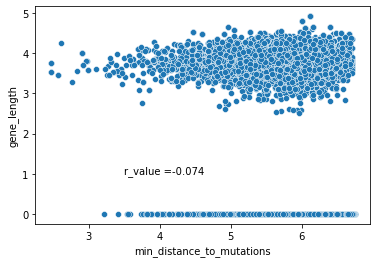

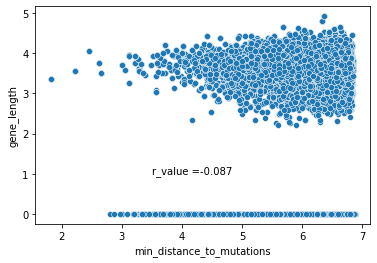

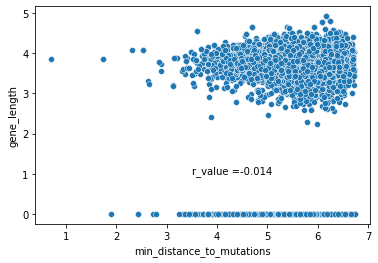

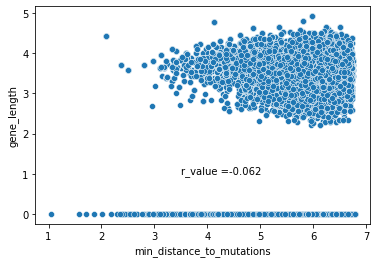

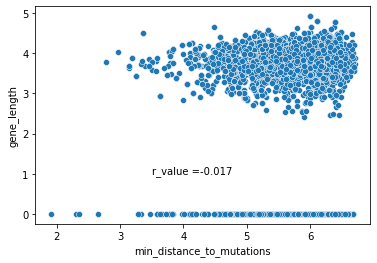

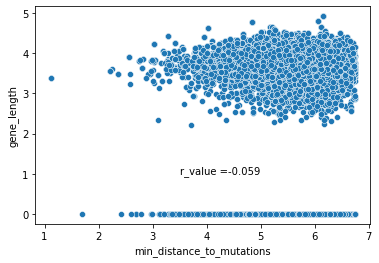

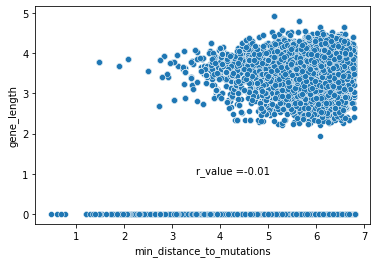

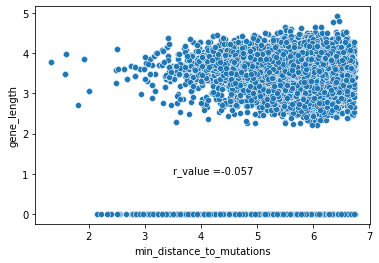

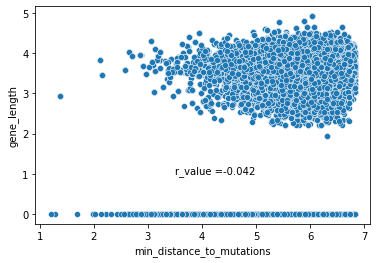

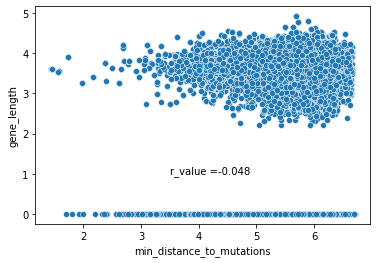

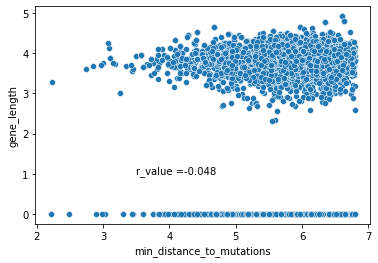

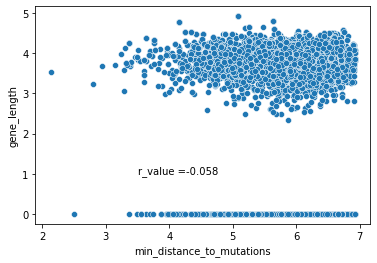

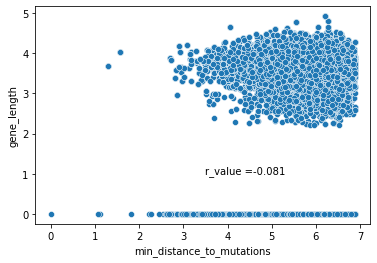

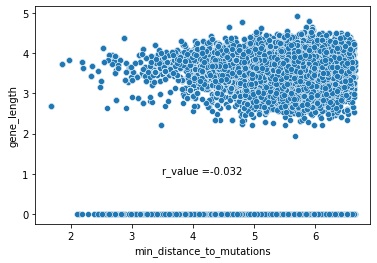

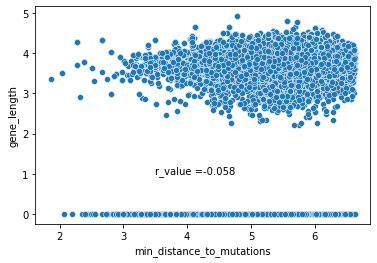

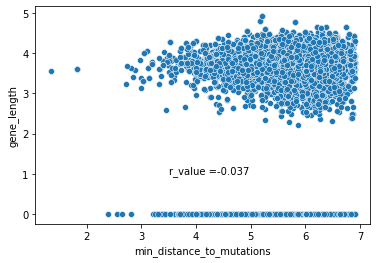

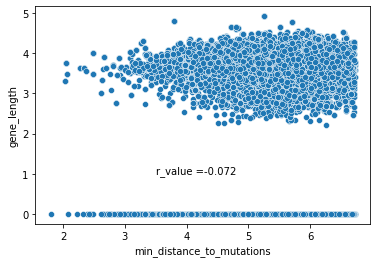

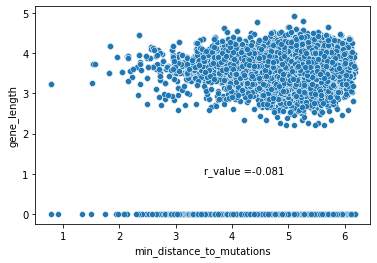

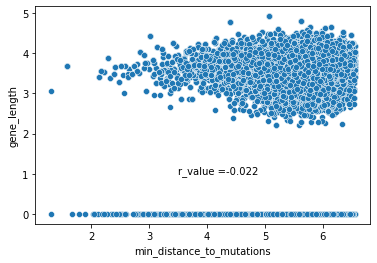

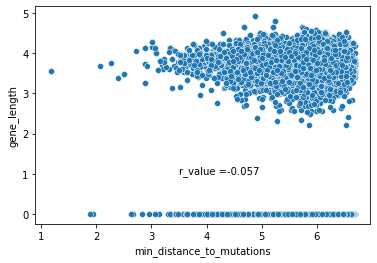

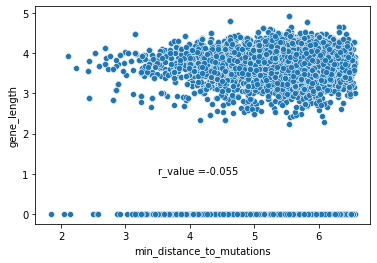

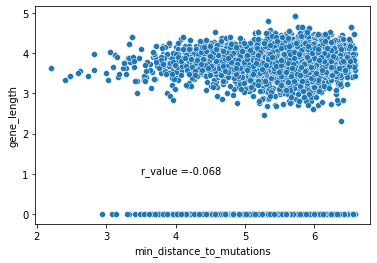

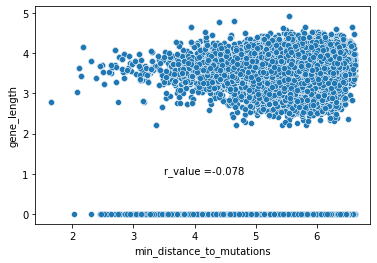

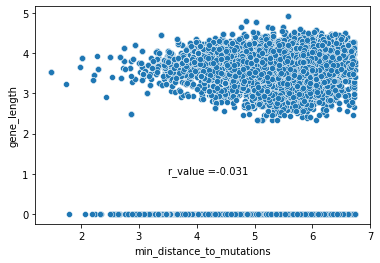

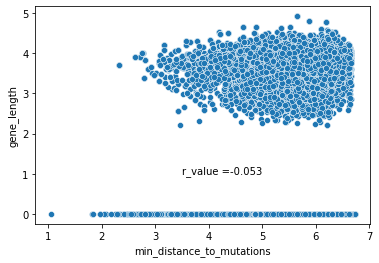

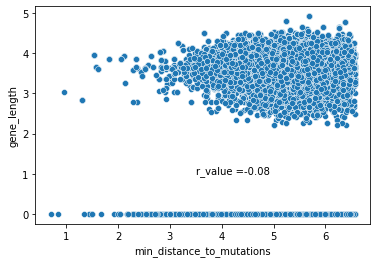

In [4]:
#### CHECKING POSSIBLE CORRELATION BETWEEN DISTANCE TO NEAREST MUTATION AND GENE LENGTH ####
for i in total: ## Not significant
    trial = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/null_hypothesis/nearest_distance_' + i + '.csv', delimiter = '\t')
    plt.figure()
    sns.scatterplot(data = trial, x = np.log10(trial['min_distance_to_mutations']), y = np.log10(trial['gene_length']))
    plt.text(3.5, 1, "r_value =" + str(round(np.log10(trial['min_distance_to_mutations']).corr(np.log10(trial['gene_length'])), 3)))